In [18]:
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# --- Config ---
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

ASSETS = [
    "SPY",  # S&P 500 ETF
    "QQQ",  # Nasdaq ETF
    "TLT",  # Long-term Treasuries
    "HYG",  # High Yield Bonds
    "GLD",  # Gold
    "XLE",  # Energy ETF
    "UUP",  # USD Index
    "AAPL",
    "JPM",
    "GE",
    "NVDA",
    "MSFT",
]
START_DATE = "2007-04-05"
END_DATE = "2025-01-01"


In [19]:
# --- 1. Fetching Adjusted Prices (Revised & More Robust) ---
print("Fetching asset prices...")

# Best Practice: Use auto_adjust=True.
# This directly gives us the adjusted prices for all tickers in a simple, clean DataFrame.
# It avoids the complex multi-level columns and prevents the KeyError.
prices = yf.download(
    ASSETS,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True, # The key change is here
    progress=False
)

# When using auto_adjust=True, yfinance provides the fully adjusted price
# in a simple DataFrame, so we only need to select 'Close' if it's there
# (it might not be if there's only one column). For simplicity, we can
# often just use the dataframe as is. Let's select the 'Close' prices
# which now contain the adjusted values.
if 'Close' in prices.columns.get_level_values(0):
    prices = prices['Close']


print("✅ Successfully fetched asset prices.")
print(f"Data shape: {prices.shape}")
print("\nPreview of the fetched prices:")
prices

Fetching asset prices...
✅ Successfully fetched asset prices.
Data shape: (4466, 12)

Preview of the fetched prices:


Ticker,AAPL,GE,GLD,HYG,JPM,MSFT,NVDA,QQQ,SPY,TLT,UUP,XLE
Date,,,,,,,,,,,,
2007-04-05,2.842305,107.533470,66.860001,NaN,30.467907,20.336740,0.472223,38.377563,102.399010,50.277496,21.080803,35.595146
2007-04-09,2.811384,106.796532,66.529999,NaN,30.611597,20.350992,0.463665,38.282841,102.540955,49.945156,21.216976,35.462540
2007-04-10,2.829396,107.103600,67.160004,NaN,30.761539,20.229898,0.458927,38.480911,102.661659,50.094105,21.148888,35.998642
2007-04-11,2.779564,107.318558,67.080002,33.281189,30.705315,20.023315,0.450675,38.076126,102.242783,50.059723,21.148888,35.779602
2007-04-12,2.767555,108.024803,66.989998,33.303516,30.736546,20.329624,0.463512,38.377563,102.697136,50.071178,21.021231,36.327213
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,257.286682,170.643921,241.440002,76.017776,238.440506,437.647400,140.197372,528.577271,597.729553,85.681717,29.370001,83.307281
2024-12-26,258.103729,171.300659,243.070007,76.211151,239.257263,436.432068,139.907410,528.218201,597.769348,85.632957,29.309999,83.238388
2024-12-27,254.685867,169.516586,241.399994,75.950096,237.318726,428.881104,136.987869,521.196533,591.476868,84.930878,29.260000,83.228539


In [20]:
import numpy as np

print("Calculating log returns...")
log_returns = np.log(prices / prices.shift(1))
# The first row of returns is always NaN after a shift, so we remove it.
log_returns.dropna(inplace=True)
print("✅ Log returns calculated.")
print(f"Log returns shape: {log_returns.shape}")

Calculating log returns...
✅ Log returns calculated.
Log returns shape: (4462, 12)


In [21]:
print("\nConstructing portfolio and saving data...")
# For an equal-weight portfolio, the return is the daily average of asset returns.
portfolio_log_returns = log_returns.mean(axis=1).to_frame(name="EqualWeightPortfolio")

# Define file paths
asset_returns_path = os.path.join(DATA_DIR, "asset_log_returns.csv")
portfolio_returns_path = os.path.join(DATA_DIR, "portfolio_log_returns.csv")

# Save to CSV
log_returns.to_csv(asset_returns_path)
portfolio_log_returns.to_csv(portfolio_returns_path)
print(f"✅ Asset returns saved to: {asset_returns_path}")
print(f"✅ Portfolio returns saved to: {portfolio_returns_path}")


Constructing portfolio and saving data...
✅ Asset returns saved to: data\asset_log_returns.csv
✅ Portfolio returns saved to: data\portfolio_log_returns.csv



Generating cumulative returns plot for sanity check...


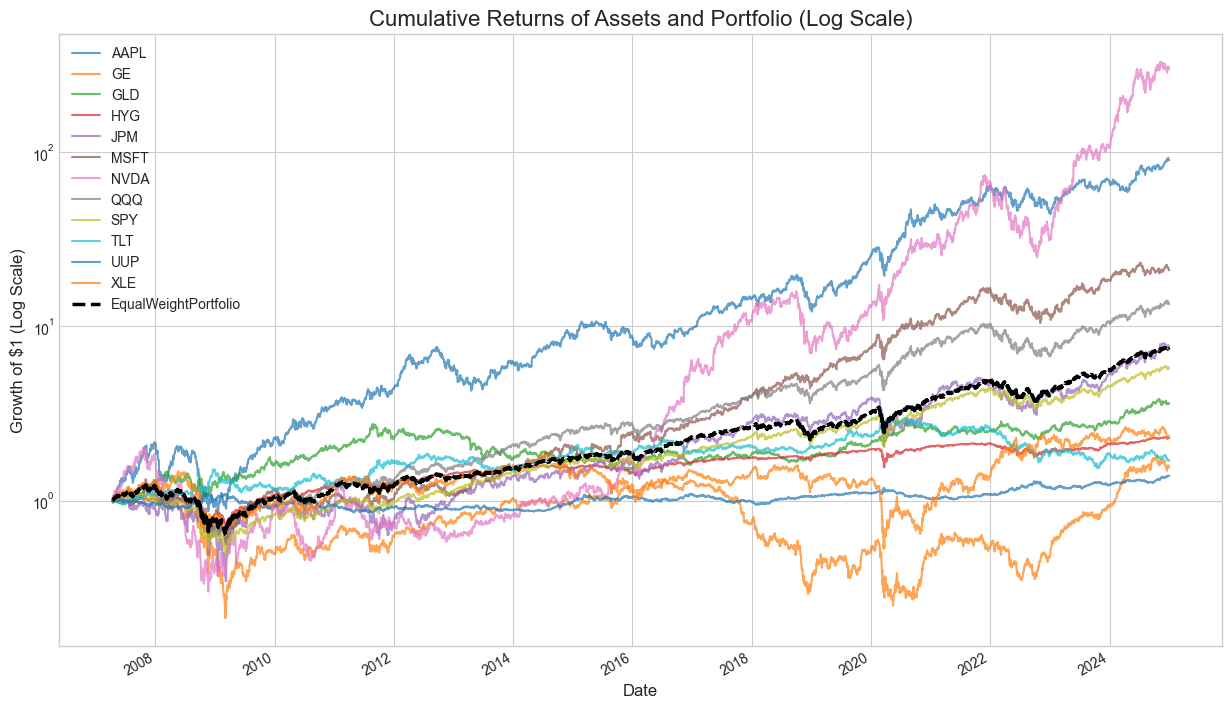


--- Phase 0 Complete ---


In [22]:
print("\nGenerating cumulative returns plot for sanity check...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 9))

# Convert log returns back to a price path for plotting.
cumulative_returns = np.exp(log_returns.cumsum())
portfolio_cumulative_returns = np.exp(portfolio_log_returns.cumsum())

cumulative_returns.plot(ax=ax, alpha=0.7)
portfolio_cumulative_returns.plot(
    ax=ax,
    color='black',
    linestyle='--',
    linewidth=2.5,
    label='Equal Weight Portfolio'
)

# A log scale is essential for visualizing high-growth assets without squashing others.
ax.set_yscale('log')
ax.set_title('Cumulative Returns of Assets and Portfolio (Log Scale)', fontsize=16)
ax.set_ylabel('Growth of $1 (Log Scale)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
plt.show()

print("\n--- Phase 0 Complete ---")